In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy import linalg
from qiskit import QuantumCircuit, transpile
from qiskit_aer import StatevectorSimulator

from lib import WaveEquationEvolution, get_bell_evolution_circ, LaplacianOperator2d

In [5]:
# Property for figures
plt.rcParams['font.family'] = "Liberation Serif"
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['font.size'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 3.0

In [6]:
backend = StatevectorSimulator()

T = 20.0
dt = 0.1
nx = 6
ny = 6

# classical
dt_cl = 0.01
op = LaplacianOperator2d(num_qubits_x=nx, num_qubits_y=ny, periodic=True)
n = op.num_qubits + 1
K = op.to_matrix(sparse=False)
KK = np.zeros((2**n, 2**n), dtype=np.complex128)
KK[:2**(n-1), 2**(n-1):] = K
KK[2**(n-1):, :2**(n-1)] = np.eye(2**(n-1))
KK[2**(n-1):, 2**(n-1):] = dt_cl*K

u = np.zeros((2, 2**nx, 2**ny))
u[0, 2**(nx-2):2**(nx-1), 2**(ny-2):2**(ny-1)] = 1
u = u.flatten()
u = u / np.linalg.norm(u)
u_list = [u]
for D in range(int(T/dt_cl)): 
    u = u + dt_cl * np.dot(KK, u)
    u_list.append(u)
u_list = np.asarray(u_list)

# quantum
op = WaveEquationEvolution(num_qubits_x=nx, num_qubits_y=ny, dim=2, diff_type='central', periodic=True)
H = op.to_matrix(sparse=False)

U = linalg.expm(-1j*H*dt)
psi_cl = np.zeros((2, 2**nx, 2**ny), dtype=np.complex128)
psi_cl[0, 2**(nx-2):2**(nx-1), 2**(ny-2):2**(ny-1)] = 1
psi_cl = psi_cl.flatten()
psi_cl = psi_cl / np.linalg.norm(psi_cl)

circ = get_bell_evolution_circ(op, dt)
circ = transpile(circ, backend=backend, optimization_level=2, seed_transpiler=42)
qc = QuantumCircuit(n)
qc.x(qc.qubits[ny-2])
qc.x(qc.qubits[nx+ny-2])
if ny-2 > 0:
    qc.h(qc.qubits[:ny-2])
if nx-2 > 0:
    qc.h(qc.qubits[ny:nx+ny-2])

psi_cl_list = [psi_cl]
psi_q_list = [backend.run(qc).result().get_statevector().data]
for D in tqdm(range(int(T/dt))):
    psi_cl = np.dot(U, psi_cl)
    psi_cl_list.append(psi_cl)
    qc = qc.compose(circ, inplace=False)
    psi_q = backend.run(qc).result().get_statevector().data
    if D == 0:
        phase = np.angle(psi_q[np.argmax(np.abs(psi_q))]) # global phase for visualization
    psi_q = np.exp(-1j*phase*(D+1)) * psi_q
    psi_q_list.append(psi_q)

psi_cl_list = np.array(psi_cl_list)
psi_q_list = np.array(psi_q_list)

100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Fo

<Figure size 640x480 with 0 Axes>

findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Fo

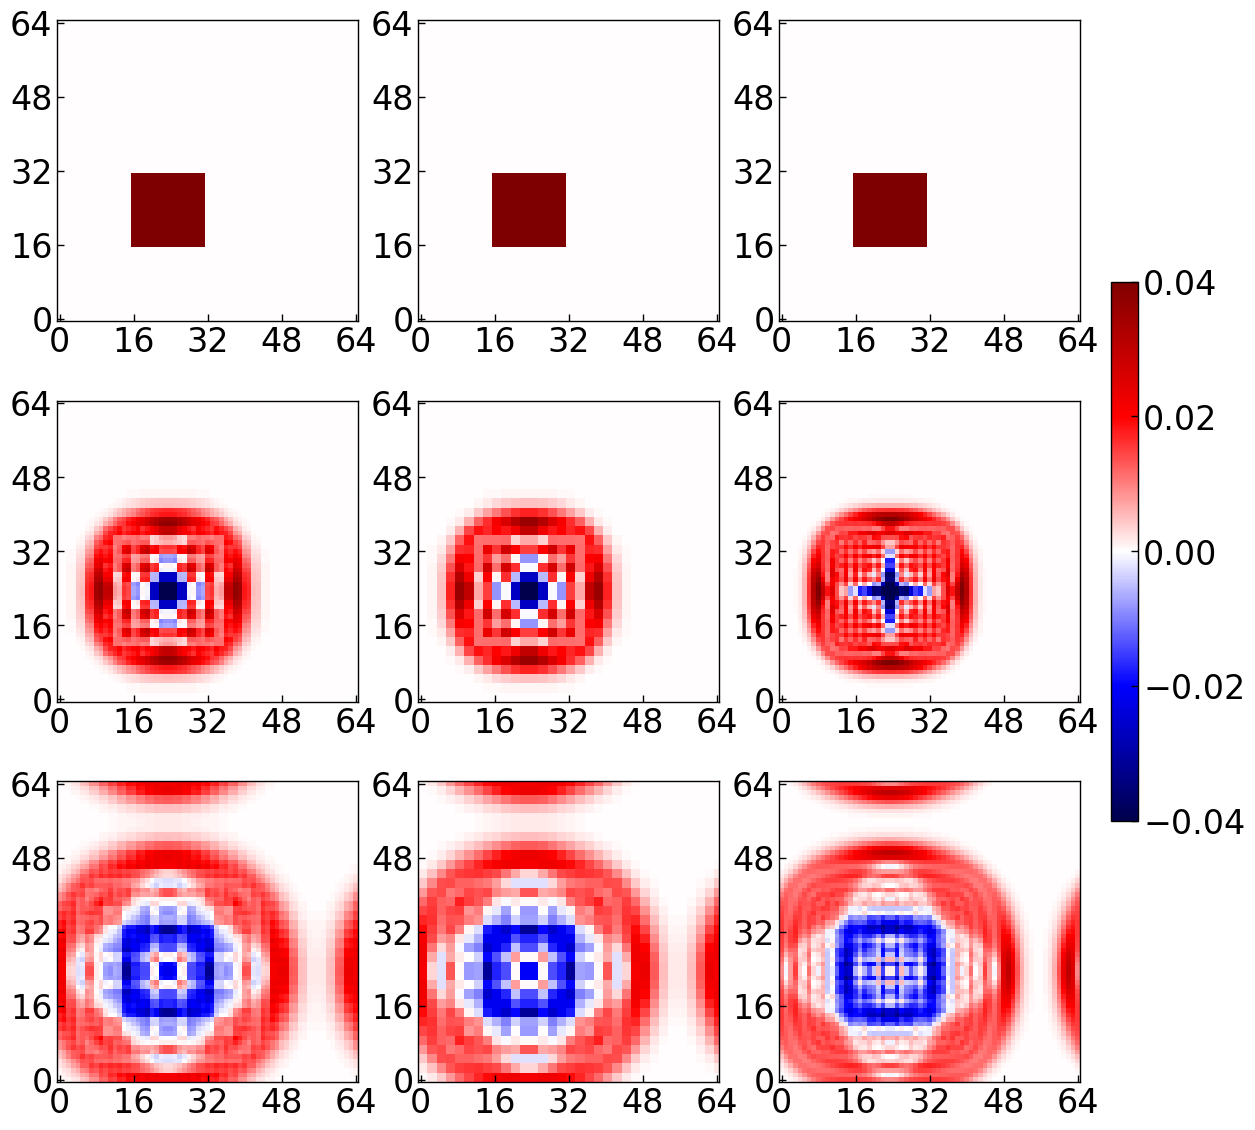

In [10]:
# visualization
idx = [0, 10, 20]

vmax = 0.04
vmin = -0.04

plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig, ax = plt.subplots(len(idx), 3, figsize=(16, 14))
for i in range(len(idx)):
    x, y = np.meshgrid(np.arange(2**nx + 1), np.arange(2**ny + 1))
    z = np.zeros((2**ny + 1, 2**nx + 1))
    z[:-1, :-1] = psi_q_list[int(idx[i]/dt), :2**(n-1)].real.reshape((2**nx, 2**ny)).transpose()
    z[-1, :] = z[0, :]
    z[:, -1] = z[:, 0]
    ax[i, 0].imshow(z, vmax=vmax, vmin=vmin, cmap='seismic', origin='lower')
    ax[i, 0].set_aspect('equal')
    ax[i, 0].set_xticks(list(range(0, 2**nx + 1, 16)))
    ax[i, 0].set_yticks(list(range(0, 2**ny + 1, 16)))
    z = np.zeros((2**ny + 1, 2**nx + 1))
    z[:-1, :-1] = psi_cl_list[int(idx[i]/dt), :2**(n-1)].real.reshape((2**nx, 2**ny)).transpose()
    z[-1, :] = z[0, :]
    z[:, -1] = z[:, 0]
    ax[i, 1].imshow(z, vmax=vmax, vmin=vmin, cmap='seismic', origin='lower')
    ax[i, 1].set_aspect('equal')
    ax[i, 1].set_xticks(list(range(0, 2**nx + 1, 16)))
    ax[i, 1].set_yticks(list(range(0, 2**ny + 1, 16)))
    z = np.zeros((2**ny + 1, 2**nx + 1))
    z[:-1, :-1] = u_list[int(idx[i]/dt_cl), :2**(n-1)].real.reshape((2**nx, 2**ny)).transpose()
    z[-1, :] = z[0, :]
    z[:, -1] = z[:, 0]
    im = ax[i, 2].imshow(z, vmax=vmax, vmin=vmin, cmap='seismic', origin='lower')
    ax[i, 2].set_aspect('equal')
    ax[i, 2].set_xticks(list(range(0, 2**nx + 1, 16)))
    ax[i, 2].set_yticks(list(range(0, 2**ny + 1, 16)))

pp = fig.colorbar(im, ax=ax.ravel().tolist(), ticks=list(np.linspace(-0.04, 0.04, 5)), pad=0.025, shrink=0.5)